---
## Step 0: Load The Data

# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

### Load the Training Data, and the Validation Set

In [54]:
# Import
import pickle
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import random

In [55]:
#Load pickled data
training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

Sizes_train = train['sizes']

---

## Step 1: Dataset Summary & Exploration

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [56]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

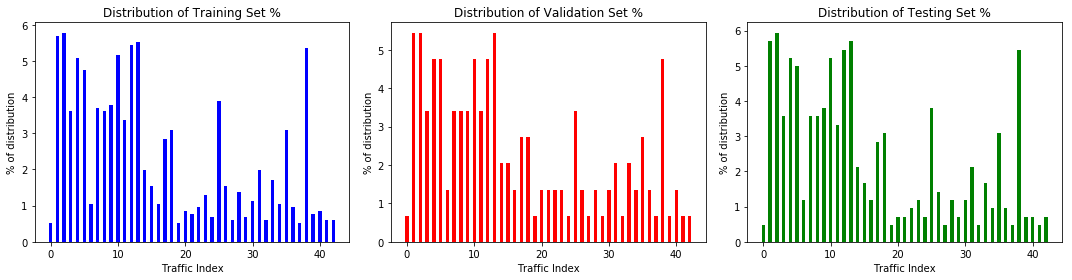

In [57]:
### Data exploration visualization code
%matplotlib inline

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 4))

#counts of each unique sign
counts_train = np.unique(y_train,return_counts = True)
counts_valid = np.unique(y_valid,return_counts = True)
counts_test  = np.unique(y_test,return_counts = True)

#convert to numpy array
counts_train_arr = np.array(counts_train)
counts_valid_arr = np.array(counts_valid)
counts_test_arr  = np.array(counts_test)

#distribution of training, validation and testing sets
distrib_train = (counts_train_arr/n_train) * 100 
distrib_valid = (counts_valid_arr/n_validation) * 100
distrib_test  = (counts_test_arr/n_test) * 100

width = 0.5

ax0.bar(counts_train[0],distrib_train[1], width, color="blue")
ax1.bar(counts_valid[0],distrib_valid[1], width, color="red")
ax2.bar(counts_test[0],distrib_test[1], width, color="green")

ax0.set_title('Distribution of Training Set %')
ax1.set_title('Distribution of Validation Set %')
ax2.set_title('Distribution of Testing Set %')

ax0.set_xlabel('Traffic Index')
ax1.set_xlabel('Traffic Index')
ax2.set_xlabel('Traffic Index')

ax0.set_ylabel('% of distribution')
ax1.set_ylabel('% of distribution')
ax2.set_ylabel('% of distribution')

fig.tight_layout()
plt.show()


----

## Step 2: Design and Test a Model Architecture


### Pre-process the Data Set (normalization and grayscale)

In [58]:
#Shuffle the images
X_train, y_train = shuffle(X_train, y_train)

10


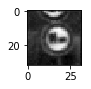

In [59]:
def GrayscaleImage(pixel_data):
    grayscaled_image = cv2.cvtColor(pixel_data, cv2.COLOR_RGB2GRAY)        
    grayscaled_image = grayscaled_image.reshape(32,32,1)
    return grayscaled_image

def CreateGrayscaleImageArray(X_data):
    X_data = np.array([GrayscaleImage(X_data[i]) for i in range(len(X_data))])
    return X_data

#Grayscale the training, validation and testing sets
X_train_gray = CreateGrayscaleImageArray(X_train)
X_valid_gray = CreateGrayscaleImageArray(X_valid)
X_test_gray  = CreateGrayscaleImageArray(X_test)

#Print a random image
index = random.randint(0, len(X_train_gray))
image = X_train_gray[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap='gray')
print(y_train[index])

In [60]:
#Normalize the training, validation & testing sets
X_train_gray = (X_train_gray - 128.0)/128.0
X_valid_gray = (X_valid_gray - 128.0)/128.0
X_test_gray  = (X_test_gray  - 128.0)/128.0

### Setup TensorFlow

In [61]:
import tensorflow as tf

EPOCHS = 50
BATCH_SIZE = 128

### Model Architecture

In [62]:
from tensorflow.contrib.layers import flatten

def TrafficClassifierNet(x,keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x24.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 24), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(24))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1   = tf.nn.relu(conv1)
    conv1   = tf.nn.dropout(conv1,keep_prob)
    
    # Layer 2: Pooling. Input = 28x28x24. Output = 14x14x24.
    maxp2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    maxp2 = tf.nn.dropout(maxp2,keep_prob)
    
    # Layer 3: Convolutional. Input = 14x14x24. Output = 10x10x48.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 24, 48), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(48))
    conv3   = tf.nn.conv2d(maxp2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    conv3   = tf.nn.relu(conv3)
    conv3   = tf.nn.dropout(conv3,keep_prob)
    
    # Layer 4: Pooling. Input = 10x10x48. Output = 5x5x48.
    maxp4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    maxp4 = tf.nn.dropout(maxp4,keep_prob)

    # SOLUTION: Flatten. Input = 5x5x48. Output = 1200.
    flat5   = flatten(maxp4)
    
    # Layer 5: Fully Connected. Input = 1200. Output = 480.
    fc5_W = tf.Variable(tf.truncated_normal(shape=(1200, 480), mean = mu, stddev = sigma))
    fc5_b = tf.Variable(tf.zeros(480))
    fc5   = tf.matmul(flat5, fc5_W) + fc5_b
    fc5    = tf.nn.relu(fc5)
    fc5    = tf.nn.dropout(fc5,keep_prob)
    
    # Layer 6: Fully Connected. Input = 480. Output = 240.
    fc6_W  = tf.Variable(tf.truncated_normal(shape=(480, 240), mean = mu, stddev = sigma))
    fc6_b  = tf.Variable(tf.zeros(240))
    fc6    = tf.matmul(fc5, fc6_W) + fc6_b    
    fc6    = tf.nn.relu(fc6)
    fc6    = tf.nn.dropout(fc6,keep_prob)
    
    # Layer 7: Fully Connected. Input = 240. Output = 43.
    fc7_W  = tf.Variable(tf.truncated_normal(shape=(240, 43), mean = mu, stddev = sigma))
    fc7_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc6, fc7_W) + fc7_b

    return logits

## Features and Labels

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.


In [63]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

keep_prob = tf.placeholder(tf.float32)


### Training Pipeline


In [64]:
rate = 0.001

logits = TrafficClassifierNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluation of the loss and accuracy of the model for the German Traffic Dataset.

In [65]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

In [66]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_gray)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_gray, y_train = shuffle(X_train_gray, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_gray[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:0.6})
            
        validation_accuracy = evaluate(X_valid_gray, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")


Training...

EPOCH 1 ...
Validation Accuracy = 0.176

EPOCH 2 ...
Validation Accuracy = 0.500

EPOCH 3 ...
Validation Accuracy = 0.718

EPOCH 4 ...
Validation Accuracy = 0.812

EPOCH 5 ...
Validation Accuracy = 0.855

EPOCH 6 ...
Validation Accuracy = 0.875

EPOCH 7 ...
Validation Accuracy = 0.903

EPOCH 8 ...
Validation Accuracy = 0.908

EPOCH 9 ...
Validation Accuracy = 0.918

EPOCH 10 ...
Validation Accuracy = 0.932

EPOCH 11 ...
Validation Accuracy = 0.932

EPOCH 12 ...
Validation Accuracy = 0.936

EPOCH 13 ...
Validation Accuracy = 0.942

EPOCH 14 ...
Validation Accuracy = 0.947

EPOCH 15 ...
Validation Accuracy = 0.949

EPOCH 16 ...
Validation Accuracy = 0.950

EPOCH 17 ...
Validation Accuracy = 0.939

EPOCH 18 ...
Validation Accuracy = 0.953

EPOCH 19 ...
Validation Accuracy = 0.950

EPOCH 20 ...
Validation Accuracy = 0.953

EPOCH 21 ...
Validation Accuracy = 0.959

EPOCH 22 ...
Validation Accuracy = 0.943

EPOCH 23 ...
Validation Accuracy = 0.961

EPOCH 24 ...
Validation Accura

### Training and Testing set accuracy for the Model

In [67]:
### Calculate the accuracy for these 5 new images. 
saver = tf.train.Saver()

with tf.Session() as sess:
    # Load the weights and bias
    saver.restore(sess, './lenet')
    train_set_accuracy = evaluate(X_train_gray, y_train) * 100
    test_set_accuracy  = evaluate(X_test_gray, y_test) * 100

print("The accuracy on the training set is {:.1f} %".format(train_set_accuracy))
print("The accuracy on the test set is {:.1f} %".format(test_set_accuracy))



The accuracy on the training set is 99.9 %
The accuracy on the test set is 95.7 %


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

28


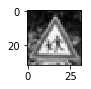

In [68]:
### Load the images and plot them here.
import cv2
import numpy as np

# Load the examples images and the mappings found on the internet
traffic_sign_example_images   = ['0.png','1.png','2.png','3.png','4.png','5.png','6.png','7.png','8.png', '9.png']
traffic_sign_example_mappings = [2,12,3,39,28,1,28,35,22,13]

image_array = []

for i in range(0, len(traffic_sign_example_images)):
    test_image = cv2.imread('Traffic-Sign-Examples/' + traffic_sign_example_images[i])
    image_array.append(test_image)

# Grayscale the example
X_test_images = CreateGrayscaleImageArray(image_array)

# Output a random image
index = random.randint(0, len(X_test_images)-1)
image = X_test_images[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap='gray')
print(traffic_sign_example_mappings[index])

### Predict the Sign Type for Each Image

In [69]:
#preprocess - normalize the example images
test_images_grayscaled = (X_test_images - 128.0)/128.0

In [70]:
# Class used to save and/or restore Tensor Variables
saver = tf.train.Saver()
prediction = tf.argmax(logits, 1)

with tf.Session() as sess:
    # Load the weights and bias
    saver.restore(sess, './lenet')
    predicted_index = sess.run(prediction,feed_dict={x: test_images_grayscaled, keep_prob:1.0})

for i in range(len(test_images_grayscaled)):
    print("Image {} index = {}, predicted index = {}".format(i, traffic_sign_example_mappings[i], predicted_index[i]))


Image 0 index = 2, predicted index = 2
Image 1 index = 12, predicted index = 12
Image 2 index = 3, predicted index = 3
Image 3 index = 39, predicted index = 39
Image 4 index = 28, predicted index = 1
Image 5 index = 1, predicted index = 1
Image 6 index = 28, predicted index = 28
Image 7 index = 35, predicted index = 35
Image 8 index = 22, predicted index = 22
Image 9 index = 13, predicted index = 13


### Analyze Performance

In [71]:
### Calculate the accuracy for these 5 new images. 

with tf.Session() as sess:
    # Load the weights and bias
    saver.restore(sess, './lenet')
    validation_accuracy_percentage = evaluate(test_images_grayscaled, traffic_sign_example_mappings) * 100

print("The accuracy on the example images from the internet is {:.1f} %".format(validation_accuracy_percentage))


The accuracy on the example images from the internet is 90.0 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [72]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

softmax_probabilities = tf.nn.softmax(logits)
top_five_probs = tf.nn.top_k(softmax_probabilities, k=5)

with tf.Session() as sess:
    saver.restore(sess, './lenet')
    top_five_probs_out = sess.run(top_five_probs, feed_dict={x: test_images_grayscaled, keep_prob:1.0})

#print(top_five_probs_out)

for i in range(len(test_images_grayscaled)):
    print('Image {}, Real Index = {}, top 5 softmax probabilites:'.format(i,traffic_sign_example_mappings[i]))
    
    for j in range(5):
        print('\t Index = {}, Probability = {:.4f}'.format(top_five_probs_out.indices[i][j], top_five_probs_out.values[i][j]))




Image 0, Real Index = 2, top 5 softmax probabilites:
	 Index = 2, Probability = 0.9990
	 Index = 5, Probability = 0.0008
	 Index = 1, Probability = 0.0001
	 Index = 7, Probability = 0.0000
	 Index = 3, Probability = 0.0000
Image 1, Real Index = 12, top 5 softmax probabilites:
	 Index = 12, Probability = 1.0000
	 Index = 40, Probability = 0.0000
	 Index = 9, Probability = 0.0000
	 Index = 38, Probability = 0.0000
	 Index = 11, Probability = 0.0000
Image 2, Real Index = 3, top 5 softmax probabilites:
	 Index = 3, Probability = 0.9510
	 Index = 2, Probability = 0.0388
	 Index = 5, Probability = 0.0101
	 Index = 1, Probability = 0.0001
	 Index = 10, Probability = 0.0000
Image 3, Real Index = 39, top 5 softmax probabilites:
	 Index = 39, Probability = 0.8568
	 Index = 2, Probability = 0.1222
	 Index = 1, Probability = 0.0072
	 Index = 40, Probability = 0.0054
	 Index = 7, Probability = 0.0018
Image 4, Real Index = 28, top 5 softmax probabilites:
	 Index = 1, Probability = 0.1355
	 Index = 3